# <center>3rd ML Month - Car Model Classification </center>
![Main Image](https://t1.daumcdn.net/cfile/tistory/2738983451EB766507)

# <a id='0'><strong>Content</strong></a>

#### 1. <a href='#1'><strong>Introduction</strong></a>  
#### 2. <a href='#2'><strong>Prepare the Dat</strong>a</a>  
#### 3. <a href='#3'><strong>Data exploration</strong></a>   
#### 4. <a href='#4'><strong>Model</strong></a>
#### 5. <a href='#5'><strong>Predict & Make submission</strong></a>

# <a id='1'><strong>Introduction<strong></a>  

### **Car Model Classification**
차 종(모델)의 분류는 일반적인 이미지 분류 예측 보다는 난이도가 있습니다. 예를 들어, 우리가 강아지와 사람을 분류 예측 해야 한다고 가정해봅시다. 사람의 이미지와 강아지의 이미지를 서로 비교해서 보면, 사람에게 드러나는 특징과 강아지에게 드러나는 특징은 비교적 차이가 존재합니다.

하지만, 자동차라는 하나의 카테고리의 이미지들 가운데, 심지어는 브랜드마저 같은 차량이 존재하는 이미지들 사이에서 차량의 모델을 분류하는 작업은 강아지와 사람을 구분하는 것 처럼 간단히 할 수 있는 문제가 아닙니다.

### **Competition**
이번 컴페티션에서는, 주어진 자동차 이미지를 총 196개의 클래스로 분류 예측하는 것이 목표입니다.  
sample_submission에 매핑된 테스트 이미지의 클래스를 예측하여 제출하시면 됩니다.

# <a id='2'><strong>Prepare the Data</strong></a>

### **Load library**
기본적인 라이브러리를 로드 합니다. 이번 베이스라인은 케라스 pretrained 모델 기반으로 실행됩니다.

In [1]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

### **File load**

주어진 파일을 확인하고 로드합니다. 

In [2]:
# 혹 다른 데이터 셋 추가(Pretrained Model Weights)로 인해 PATH가 변경된다면 아래 PATH를 수정
DATA_PATH = '.\\data\\'
os.listdir(DATA_PATH)

['class.csv',
 'cropped_test',
 'cropped_train',
 'sample_submission.csv',
 'test',
 'test.csv',
 'train',
 'train.csv']

Data Description에 있는 파일 세부 정보입니다.
* **train.csv** - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* **test.csv** - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* **submission.csv** - Test셋과 대응되는 제출 파일
* **class.csv** - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
* **train** - Train 이미지 파일
* **test** - Test 이미지 파일

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

# <a id='3'><strong>Data Exploration</strong></a>
실제 데이터가 Description과 일치 하는지, 데이터는 어떻게 구성되어 있고 클래스 별로 어떤 분포를 가지고 있는지 등 데이터에 대한 전반적인 궁금증을 해결해보는 과정입니다.

### **Check Data**
Data Description에 나와 있는 컬럼 별 세부 설명 입니다.
* **img_file** - 데이터 셋의 각 로우와 연결되는 이미지 파일 이름
* **bbox_x1** - 바운딩 박스 x1 좌표 (좌상단 x)
* **bbox_y1** - 바운딩 박스 y1 좌표 (좌상단 y)
* **bbox_x2** - 바운딩 박스 x2 좌표 (우하단 x)
* **bbox_y2** - 바운딩 박스 y2 좌표 (우하단 y)
* **class** - 예측하려는 차종(Target)
* **id** - 각 데이터 셋에 기입 되어 있는 클래스 id
* **name** - 클래스 id에 대응되는 실제 차종 레이블

In [4]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [5]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [6]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


In [7]:
# Data 갯수
print("Number of Train Data : {}".format(df_train.shape[0]))
print("Number of Test Data : {}".format(df_test.shape[0]))

Number of Train Data : 10016
Number of Test Data : 6169


In [8]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [9]:
print("타겟 클래스 총 갯수 : {}".format(df_class.shape[0]))
print("Train Data의 타겟 종류 갯수 : {}".format(df_train['class'].nunique()))

타겟 클래스 총 갯수 : 196
Train Data의 타겟 종류 갯수 : 196


### **Class Distribution**  
분류 문제에서 가장 먼저 의심해봐야 할 부분이 바로 Target Class의 분포입니다. 학습에 사용해야 하는 Train Set의 타겟 분포를 확인해서 밸런스가 어느정도인지 체크해야 합니다.

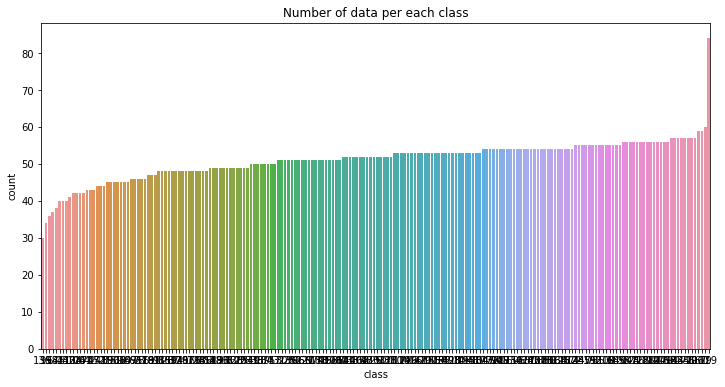

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

In [11]:
cntEachClass = df_train["class"].value_counts(ascending=False)
print("Class with most count  : {}".format(cntEachClass.max()))
print("Most Count : {}".format(cntEachClass.index[0]))
print("Class with fewest count  : {}".format(cntEachClass.min()))
print("Fewest Count : {}".format(cntEachClass.index[-1]))

print("Mean  : {}".format(cntEachClass.mean()))

Class with most count  : 84
Most Count : 119
Class with fewest count  : 30
Fewest Count : 136
Mean  : 51.10204081632653


In [12]:
cntEachClass.describe()

count    196.000000
mean      51.102041
std        5.350274
min       30.000000
25%       48.750000
50%       52.000000
75%       54.000000
max       84.000000
Name: class, dtype: float64

대체적으로 카운트 수는 비슷합니다. 84번 클래스가 유독 카운트 숫자가 높고 평균은 51정도 입니다.

### **Image Visualization**
파이썬 커널에서 이미지를 보고 싶을땐 어떻게 할까요? 이미지를 로드하는 방법은 여러 방법이 있지만, 이 커널에서는 PIL 라이브러리를 사용합니다.  
Documentation : https://pillow.readthedocs.io/en/stable/

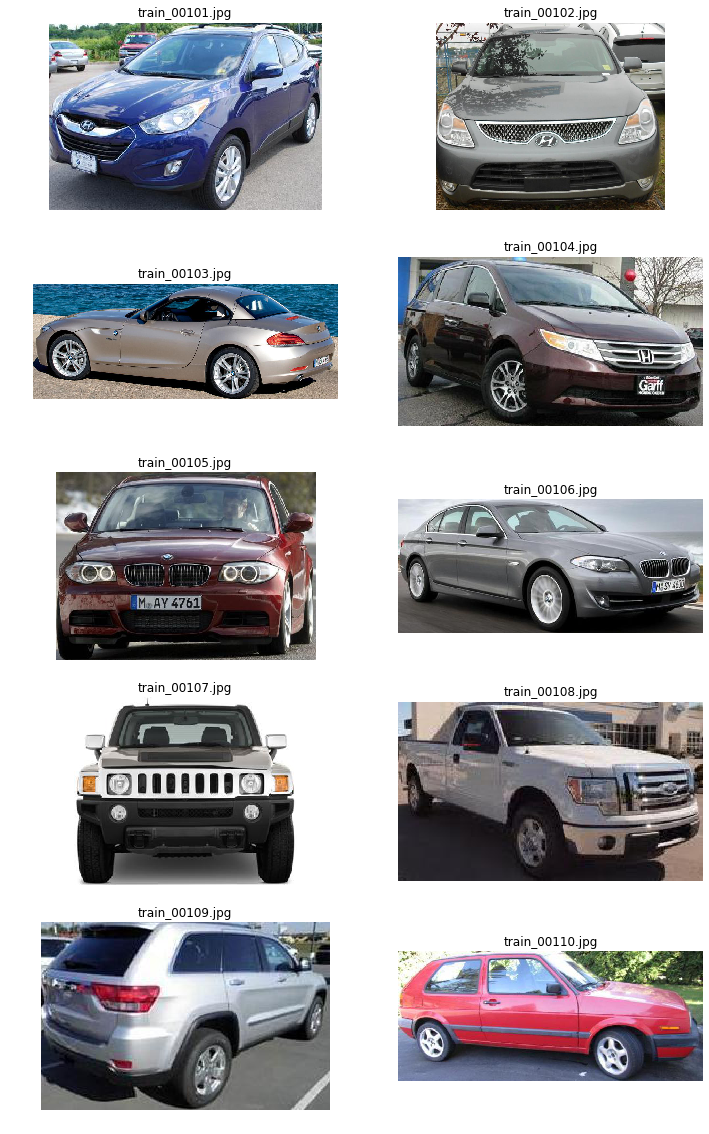

In [13]:
import PIL
from PIL import ImageDraw

tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

### **Bounding Box**
이미지 대회를 처음 해보시는 분이라면, 이 바운딩 박스라는 것이 생소할 수 있습니다.
 
바운딩 박스란?  
이미지 내부에서 특정 Object를 박스로 레이블한 좌표를 말하며, 보통 좌측 상단 (x1, y1)과, 우측 하단 (x2, y2) 좌표가 주어져서   
직사각형 모양의 박스를 그릴 수 있게됩니다. 이때, 좌표는 이미지의 픽셀 좌표입니다.

In [14]:
def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

def make_boxing_img(img_name) :
    if img_name.split('_')[0] == "train" :
        PATH = TRAIN_IMG_PATH
        data = df_train
    elif img_name.split('_')[0] == "test" :
        PATH = TEST_IMG_PATH
        data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

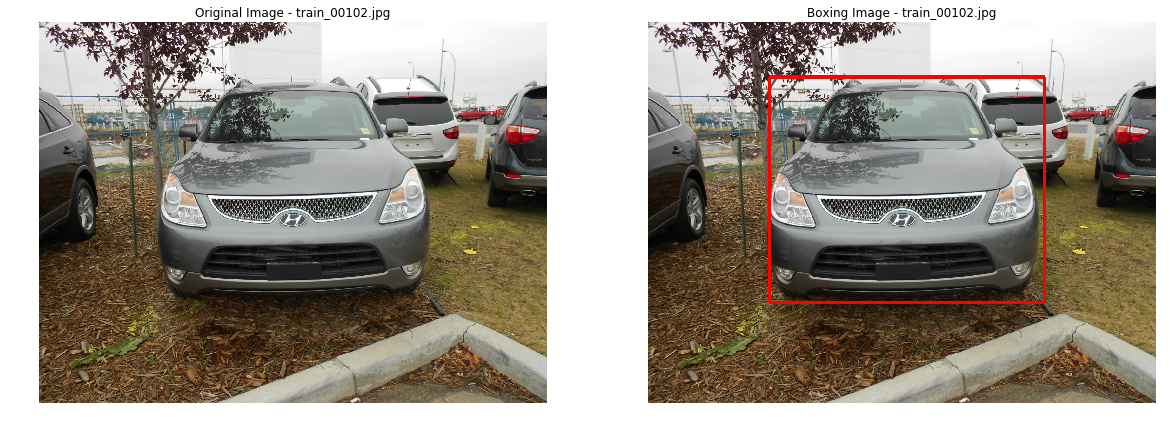

In [15]:
f_name = "train_00102.jpg"

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
# Original Image
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

# Image included bounding box
plt.subplot(1, 2, 2)
boxing = make_boxing_img(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

왼쪽 그림과 같이 어떤 이미지에는 내가 필요로하는 Target Object 뿐만 아니라 상관 없는 다른 Object(Noise)가 섞여 있을 수 있습니다. 이런 경우에 이미지 내부에서 필요한 Object를 명확히 표시하기 위해 Bounding Box를 사용합니다.   
(실제로 이미지를 모델에 넣을때는 Box 바깥 부분은 잘라서 사용합니다.)

이번 컴페티션은 Bounding Box 좌표가 이미 주어져 있습니다. 만약 Bounding Box 좌표가 주어지지 않는다면 어떻게 해야 할까요? 이런 경우에는 직접 레이블을 하거나, Bounding Box를 좌표를 예측하는 딥러닝 모델을 설계해볼 수도 있습니다. 

이번 커널에서는 바운딩박스를 활용하지 않습니다. 하지만, 꼭 구현해보시길 권장합니다.

# <a id='4'><strong>Model</strong></a>
이제 본격적으로 이미지 분류 모델을 만들어 봅시다.  
이번 커널에서는 ResNet50 Pretrained Model을 불러와서 사용합니다.

### **Train set, valid set split**
모델 학습을 하기 전에 주어진 Train 데이터 셋을 어떻게 활용할 지 생각해야 합니다. 

![train_val_test](https://t1.daumcdn.net/cfile/tistory/9951E5445AAE1BE025)

일반적으로, 주어진 Train 데이터를 위와 같이 Train/validation으로 나누는 작업을 진행하는데요.   
Training 데이터 수가 많으면 좋을텐데 왜 굳이 이렇게 나누는 걸까요?

물론, Train 데이터를 모두 사용하면 데이터가 다양해지니 성능이 더 잘 나올 수 있습니다. 하지만, 학습한 후 모델이 잘 일반화 되었는지 확인해야 하는데, 여기서 검증(Validation) 데이터 셋이 필요합니다. 데이터 컴페티션의 경우 보통 평가를 위한 Test 데이터가 주어집니다. Training 데이터로 모델을 만들고 테스트 데이터로 확인 하면 되는 것이죠. 그런데 이번 컴페티션 같은 경우는 하루에 제출 횟수가 제한되어 있습니다. 그럼 하루에 5번 제출한 뒤로는 더이상 검증을 할 수 없게 되겠죠?

그래서 만든 모델이 얼마나 괜찮은 모델인지 검증 데이터를 통해 제출해보지 않고(중요) 가늠해볼 수 있는 것입니다. 그래도 데이터가 너무 적어 검증데이터를 만들지 못할거 같나요? 그렇기 때문에, 사람들은 캐글에서는 높은 점수를 위해 대부분 Cross Validation set을 구성합니다. 

이 커널에서는 Cross Validation을 따로 만들지는 않습니다. 필요하다면 한번 구현해보시길 바랍니다.

참고)  
캐글 디스커션에서 CV, LB라는 용어가 자주 등장합니다. 눈치 빠른분은 아시겠지만 CV가 바로 Cross Validation 점수입니다. LB는 리더보드에 올라간 Public Score를 의미합니다. 디스커션에서 어떤 모델을 시도 했는데 CV와 LB가 어떻냐는 말은 Train set 만으로 검증된 점수와 실제 Test Score와 얼마나 차이가 나는지를 의미합니다. 모델이 과연 일반화가 잘 되어 있는지 확인하기 위해서죠.

### **Train_test_split**

In [14]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(8012, 2)
(2004, 2)
(6169, 1)


사이킷런의 train_test_split함수를 활용하여 Train 셋을 Train / validation 셋으로 나눴습니다.   
혹시나 해서 말씀드리지만, train_test_split()이라고 해서 test라는 글자에 너무 많은 의미를 부여하지는 않아도 됩니다.  
우리가 원하는 건 특정 array를 원하는 비율로 나누기만 하면 되니까요.

### **Generator**

자, 제너레이터 입니다. 개인적으로 이미지 프로세싱에서 없어서는 안 될 필수 과정이라고 생각합니다. 정말 2번 3번 설명해도 부족함이 없습니다. 제너레이터가 왜 중요하고, 특히, 이번 컴페티션 혹은 딥러닝 파이프라인에서 어떤 효과가 있는지 잠깐 짚고 넘어가겠습니다.

#### **Generator의 이점?**
제너레이터는 코랩이나 캐글 커널같은 클라우드 환경 또는 일반적인 로컬 환경에서 정말 유용하게 쓰일 수 있습니다. 그 이유는 보통 이러한 환경은 메모리가 충분하지 않기 때문이죠. 특히나 이미지 처럼 파일하나의 용량이 매우 큰 경우, 한번에 모든 파일을 메모리에 적재하게 되면 상당히 큰 부담이 됩니다. 배치사이즈 단위 만큼 파일을 불러와 학습하고 끝나면 다시 불러와서 학습하는 방법을 반복하기 때문에 전체 학습을 하더라도 메모리를 조금만 사용하게 되는 것입니다.

### **Keras DataGenerator**
지금껏 불편하게 제너레이터를 만들어 사용했다면 케라스에는 정말 편한 제너레이터 함수가 있습니다. 케라스 ImageDataGenerator는 제너레이터의 기능은 물론 제너레이터를 정의하면서 동시에 Data에 원하는 Noise까지 부여할 수 있습니다. 또한 Documentaion을 참고하시면 생각보다 많은 기능이 있으니 이번 기회에 한번 사용해 보시는 것도 좋을 것 같네요.

Documentaion : https://keras.io/preprocessing/image/

추가) 이번 커널에서는 케라스 내부의 DataGenerator를 사용합니다. 하지만, 주어진 데이터가 이미지가 아닌 경우에는 제너레이터를 직접 설계해야 하는 경우도 있습니다. 그러니 케라스 제너레이터에 너무 익숙해지는 것 보다는 직접 제너레이터를 설계해보는 것도 강력히 추천합니다!

In [17]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    zoom_range=0.10,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe = X_train, 
    directory = os.path.join(DATA_PATH, 'train'),
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = X_val, 
    directory = os.path.join(DATA_PATH, 'train'),
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = os.path.join(DATA_PATH, 'test'),
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 8012 images belonging to 196 classes.
Found 2004 images belonging to 196 classes.
Found 6169 images.


### **Loading Pretrained Model - ResNet50**

![resnet](https://cdn-images-1.medium.com/max/987/1*pUyst_ciesOz_LUg0HocYg.png)


그 유명한 ResNet입니다. Residual(잔차)를 이용한 획기적인 모델로 평가됩니다. 보통 딥러닝 모델을 구성할 때 직접 만들어 보는것도 좋지만, 이 작업은 상당히 많은 시간과 노력이 필요하기 때문에, 이미 성능이 입증된 모델을 불러와서 사용해보는 것도 좋은 방법이죠.

Pretrained Model을 불러오기 위해서는 커널의 Internet 옵션이 활성화 되어 있어야 합니다.  

ResNet arxiv : http://www.arxiv.org/abs/1512.03385

In [18]:
resNet_model = ResNet50(include_top=False, input_shape=(224,224,3))
# resNet_model.summary()

219062272/219055592 [==============================] - 27s 0us/step


In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in resNet_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
model.add(resNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


Pretrained Model을 사용할 때 한가지 주의할 점이 있습니다. Pretrained 모델은 경우에 따라 다양하게 사용될 수 있기 때문에 Model output부분을 잘라버린 채 로드 되는 경우가 있습니다.(include_top=False) 이 경우에는 직접 output을 만들어야 되겠죠? 우리는 196개의 class를 분류하기 때문에 위와 같이 만들었습니다.

참고)  
케라스에는 모델을 생성하는 방법이 2가지가 있습니다. 하나는 위처럼 Sequential을 사용하는 것이고 하나는 Model을 사용하는 방법입니다. 2가지 모두 많이 사용하니 Model도 한번 사용해보세요.

### **Model Compile**
이제 Model을 만들었으니 어떻게 학습할 지 정해야 합니다. 어떤 방법으로, 어떤 속도로, 어떤 지표를 기준으로 등등 정할 수 있고 필요시에는 각각의 함수를 직접 구현해볼 수도 있습니다. 하지만, 보통은 기본으로 주어지는 것들을 사용합니다.

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

### **Model Training**
이제 진짜로 학습을 해봅시다. 학습에는 시간이 조금 걸리니 커피라도 한 잔 하시는게 어떨까요?

In [21]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [22]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

# ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
251/251 [==============================] - 199s 794ms/step - loss: 5.3030 - acc: 0.0105 - val_loss: 5.4884 - val_acc: 0.0100
Epoch 2/20
 65/251 [======>.......................] - ETA: 1:57 - loss: 5.1045 - acc: 0.0178

KeyboardInterrupt: 

### **Training History Visualization**
학습된 결과를 plot으로 그려볼 수 있습니다. 모델 학습 로그를 통해서 확인할 수도 있지만, 전반적인 학습 형태를 한눈에 파악하기에는 그래프만 한 것이 없습니다.

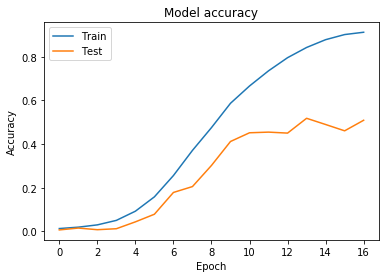

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

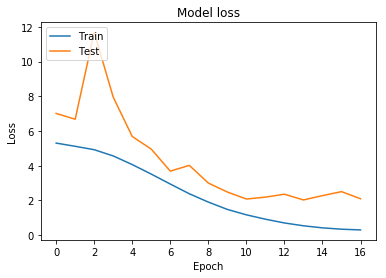

In [24]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# <a id='5'><strong>Predict & Make submission</strong></a>  
겨우 모델 학습이 끝났군요! 하지만, 아직 끝나지 않았습니다. 모델이 테스트 데이터에도 잘 적용되는지 predict를 해보고 제출물을 만들어야 합니다.

### **Model Predict**

In [25]:
%%time
test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

193/193 [==============================] - 79s 408ms/step
CPU times: user 1min 9s, sys: 10.3 s, total: 1min 19s
Wall time: 1min 18s


Predict 또한 제너레이터를 사용합니다. 제너레이터는 메모리가 부족한 우리들에게 꼭 필요한 기능입니다!

### **Make submission**

Inference가 끝난 결과를 이제 sample_submission 파일에 매핑해야 합니다. sample_submission 파일을 불러온 후 예측한 결과를 매핑합니다.

중요)  
케라스 제너레이터를 사용하는 경우에는 타겟(클래스)의 카테고리컬 매핑이 제너레이터 임의로 결정됩니다. 따라서 제너레이터가 가지고 있는 class index 딕셔너리를 불러와 새롭게 매핑해주어야 합니다.

In [26]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,148
4,test_00005.jpg,17


드디어 완료 되었습니다. 하지만, 여기서 끝이 아니죠!   
첫 제출을 성공하셨다면 이제는 모델 성능을 어떻게하면 더 올릴 수 있을지 연구할 때입니다.   
끝나는 시간까지 계속 킵고잉해서 좋은 성능을 낼 때까지 달립시다. 모두 화이팅!

#### **Reference:**
https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c  
https://keras.io/  
http://www.arxiv.org/abs/1512.03385  
https://pillow.readthedocs.io/en/stable/  
https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras